# Задание: автоматические отчеты

Соберите отчет по результатам ЕГЭ в 2018-2019 году, используя данные

https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv

и отправьте его в HTML формате по адресу support@ittensive.com, используя только Python.

В отчете должно быть:
- общее число отличников (учеников, получивших более 220 баллов по ЕГЭ в Москве),
- распределение отличников по округам Москвы,
- название школы с лучшими результатами по ЕГЭ в Москве.

Диаграмма распределения должна быть вставлена в HTML через data:URI формат (в base64-кодировке).

**Дополнительно**: приложите к отчету PDF документ того же содержания (дублирующий письмо).

In [1]:
import warnings
warnings.simplefilter('ignore')

import binascii
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 7)

df = pd.read_csv('https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv', sep=';')
df = df.set_index('ID')
df = df[df['YEAR'] == '2018-2019'][['PASSES_OVER_220', 'PASSER_UNDER_160', 'AdmArea', 'EDU_NAME']]
df['AdmArea'] = df['AdmArea'].map(lambda area: area.replace('административный округ', '').strip())
df['ege_result'] = df['PASSES_OVER_220'] / (df['PASSES_OVER_220'] + df['PASSER_UNDER_160'])
df.head()

,PASSES_OVER_220,PASSER_UNDER_160,AdmArea,EDU_NAME,ege_result
ID,,,,,
9734,41,112,Восточный,Государственное бюджетное общеобразовательное ...,0.267974
9735,12,44,Восточный,Государственное бюджетное общеобразовательное ...,0.214286
9736,19,37,Восточный,Государственное бюджетное общеобразовательное ...,0.339286
9737,1,3,Восточный,Автономная некоммерческая организация средняя ...,0.250000
9738,25,51,Западный,Государственное бюджетное общеобразовательное ...,0.328947


### Данные для отчета

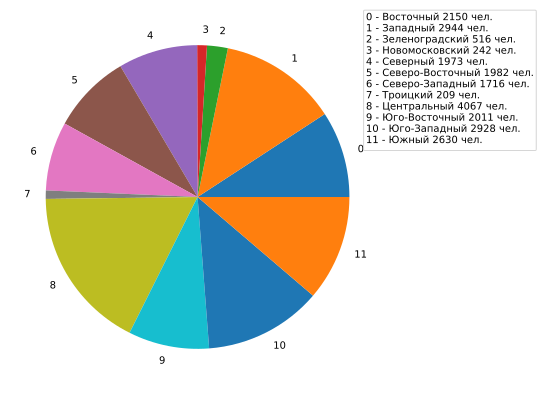

In [2]:
the_best_pupils_total = df['PASSES_OVER_220'].sum()
the_best_ege_score = df['ege_result'].max()
the_best_schools = df[df['ege_result'] == the_best_ege_score][['EDU_NAME', 'ege_result']].rename(
    columns={'EDU_NAME': 'Название школы', 'ege_result': 'Отличников'}
).set_index('Название школы')
the_best_schools['Отличников'] = (the_best_schools['Отличников'] * 100).astype(str) + '%'

report_df = df.groupby('AdmArea')['PASSES_OVER_220'].sum().reset_index().rename(
    columns={'AdmArea': 'Округ', 'PASSES_OVER_220': 'Количество отличников'}
)
report_df['description'] = report_df.index.astype(str)\
    + ' - ' + report_df['Округ'].astype(str) + ' ' + report_df['Количество отличников'].astype(str) + ' чел.'
report_df['Количество отличников'].plot(
    kind='pie',
    labels=report_df.index.astype(str),
    #title='Распределение отличников по округам Москвы',
    label=''
)
plt.legend([], title='\n'.join(report_df.description), bbox_to_anchor=(0.6, 0, 0.8, 1), fontsize=6)
plt.savefig('homework_4.png');

with open('homework_4.png', 'rb') as file:
    img = 'data:image/png;base64,' + binascii.b2a_base64(file.read(), newline=False).decode('UTF-8')

### Отчет в html и в pdf

In [3]:
from jinja2 import Template
import pdfkit

html_template = '''
<html>
    <head>
        <title>Результаты ЕГЭ в 2018-2019 году,</title>
        <meta charset="utf-8"/>
        <style>
            thead {
                text-align: center;
            }
            tbody {
                text-align: left;
            }
        </style>
    </head>
    <body>
        <h1>Распределение отличников по округам Москвы</h1>
        <img src="{{data.image}}" alt="Распределение посетителей">
        <h2>Общее число отличников {{data.the_best_pupils_number}}</h2>
        <h1>Школы с лучшими результатами по ЕГЭ в Москве</h1>
        {{data.table}}
    </body>
</html>
'''

html = Template(html_template).render(
    data={
        'image': img,
        'the_best_pupils_number': the_best_pupils_total,
        'table': the_best_schools.to_html()
    }
)


options = {
    'page-size': 'A4',
    'header-right': '[page]'
}
config = pdfkit.configuration(wkhtmltopdf='C:/Program Files/wkhtmltopdf/bin/wkhtmltopdf.exe')
pdfkit.from_string(html, 'homework_4.pdf', options=options, configuration=config)

True

### Отправка отчета в HTML формате по адресу support@ittensive.com, используя только Python

In [4]:
import smtplib
from email import encoders
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart

letter = MIMEMultipart()
letter['From'] = 'Максим <mo@avw.ru>'
letter['Subject'] = 'Задание - автоматические отчеты'
letter['Content-Type'] = 'text/html; charset=utf-8'
letter['To'] = 'support@ittensive.com'
letter.attach(MIMEText(html, 'html'))

attachement = MIMEBase('application', 'pdf')
attachement.set_payload(open('homework_4.pdf', 'rb').read())
attachement.add_header('Content-Disposition', 'attachment; filename="homework_4.pdf"')
encoders.encode_base64(attachement)

letter.attach(attachement)

user = "###"
password = "###"

server = smtplib.SMTP_SSL("smtp.beget.com", 465)
server.login(user, password)
server.sendmail("mo@avw.ru", "support@ittensive.com", letter.as_string())
server.quit()

(221, b'smtp.beget.com closing connection')